# Data Loading

In [476]:
from __future__ import print_function, division
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
import os
import numpy as np

# defining customized Dataset class for Udacity

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class UdacityDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, select_camera=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            select_camera (string): 'left_ / right_ / center_camera'
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        camera_csv = pd.read_csv(csv_file)
        assert select_camera in ['left_camera', 'right_camera', 'center_camera'], "Invalid camera: {}".format(select_camera)
        if select_camera:
            camera_csv = camera_csv[camera_csv['frame_id']==select_camera]
        self.camera_csv = camera_csv
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.camera_csv)
    
    def read_data_single(self, idx):
        path = os.path.join(self.root_dir, self.camera_csv['filename'].iloc[idx])
        image = io.imread(path)
        timestamp = self.camera_csv['timestamp'].iloc[idx]
        frame_id = self.camera_csv['frame_id'].iloc[idx]
        angle = self.camera_csv['angle'].iloc[idx]
        torque = self.camera_csv['torque'].iloc[idx]
        speed = self.camera_csv['speed'].iloc[idx]
        
        if self.transform:
            image = self.transform(image)
        angle = torch.tensor(angle)
        torque = torch.tensor(torque)
        speed = torch.tensor(speed)
            
        return image, timestamp, frame_id, angle, torque, speed
    
    def read_data(self, idx):
        if isinstance(idx, list):
            data = None
            for i in idx:
                new_data = self.read_data(i)
                if data is None:
                    data = [[] for _ in range(len(new_data))]
                for i, d in enumerate(new_data):
                    data[i].append(new_data[i])
                
            for stack_idx in [0, 3, 4, 5]:
                data[stack_idx] = torch.stack(data[stack_idx])
            
            return data
        
        else:
            return self.read_data_single(idx)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data = self.read_data(idx)
        
        sample = {'image': data[0],
                  'timestamp': data[1],
                  'frame_id': data[2],
                  'angle': data[3],
                  'torque': data[4],
                  'speed': data[5]}
        
        return sample

In [477]:
# test the UdacityDataset class
from torch.utils.data import BatchSampler, SequentialSampler, RandomSampler

udacity_dataset = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                 root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                 transform=transforms.Compose([transforms.ToTensor()]),
                                 select_camera='center_camera')

# using DataLoader and batch_size
# this allows multithreading so it has a higher efficiency

sampler = SequentialSampler(udacity_dataset)
dataloader = DataLoader(udacity_dataset, sampler=BatchSampler(sampler, batch_size=4, drop_last=False), collate_fn=(lambda x: x[0]), num_workers=1)

for i_batch, sample_batched in enumerate(dataloader):
    print(sample_batched['image'].shape)
    break

torch.Size([4, 3, 480, 640])


In [470]:
# generate Batch with consecutive frames taken from input data

from torch.utils.data import Sampler
import random

class ConsecutiveBatchSampler(Sampler):
    
    def __init__(self, data_source, batch_size, seq_len, drop_last=False, shuffle=True):
        r""" Sampler to generate consecutive Batches
        
        Args:
            data_source: Source of data
            batch_size: Size of batch
            seq_len: Number of frames in each sequence (used for context for prediction)
            drop: Wether to drop the last incomplete batch
            shuffle: Wether to shuffle the data
        Return:
            List of iterators, size: [batch_size x seq_len x n_channels x height x width]
        """
        self.data_source = data_source
        
        assert seq_len >= 1, "Invalid batch size: {}".format(seq_len)
        self.seq_len = seq_len
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.batch_size = batch_size
    
    def __iter__(self):
        data_size = len(self.data_source)
        start_indices = list(range(data_size))
        if self.shuffle:
            random.shuffle(start_indices)
        
        batch = []
        for idx, ind in enumerate(start_indices):
            if data_size - idx < self.batch_size and self.drop_last: # if last batch
                break
                
            seq = []
            if ind + 1 < self.seq_len:
                seq.extend([0]*(self.seq_len - ind - 1) + list(range(0, ind+1)))
            else:
                seq.extend(list(range(ind-self.seq_len+1, ind+1)))
            
            batch.append(seq)
            
            if len(batch) == self.batch_size or idx == data_size - 1:
                yield batch
                batch = []

    
    def __len__(self):
        length = len(self.data_source)
        batch_size = self.batch_size
        
        if length % batch_size == 0 or self.drop_last:
            return length // batch_size
        
        return length // batch_size + 1

In [505]:
def show_sample(sample):
    r""" Helper function for (batch) sample visualization
    
    Args:
        sample: Dictionary
    """
    image_dims = len(sample['image'].shape)
    assert image_dims <= 5, "Unsupported image shape: {}".format(sample['image'].shape)
    if image_dims == 3:
        plt.imshow(sample['image'])
    else:
        n0 = sample['image'].shape[0]
        n1 = sample['image'].shape[1] if image_dims == 5 else 1
        images_flattened = torch.flatten(sample['image'], end_dim=-4)
        fig, ax = plt.subplots(n0, n1, figsize=(25, 15))
        for i1 in range(n1):
            for i0 in range(n0):
                image = images_flattened[i0 * n1 + i1]
                axis = ax[i0, i1]
                axis.imshow(image.permute(1,2,0))
                axis.axis('off')
                axis.set_title("t={}".format(sample['timestamp'][i0][i1]))
                axis.text(10, 30, sample['frame_id'][i0][i1], color='red')
            
    


Sample image:
<class 'torch.Tensor'>
torch.Size([4, 5, 3, 480, 640])
Sample angle:
<class 'torch.Tensor'>
torch.Size([4, 5])


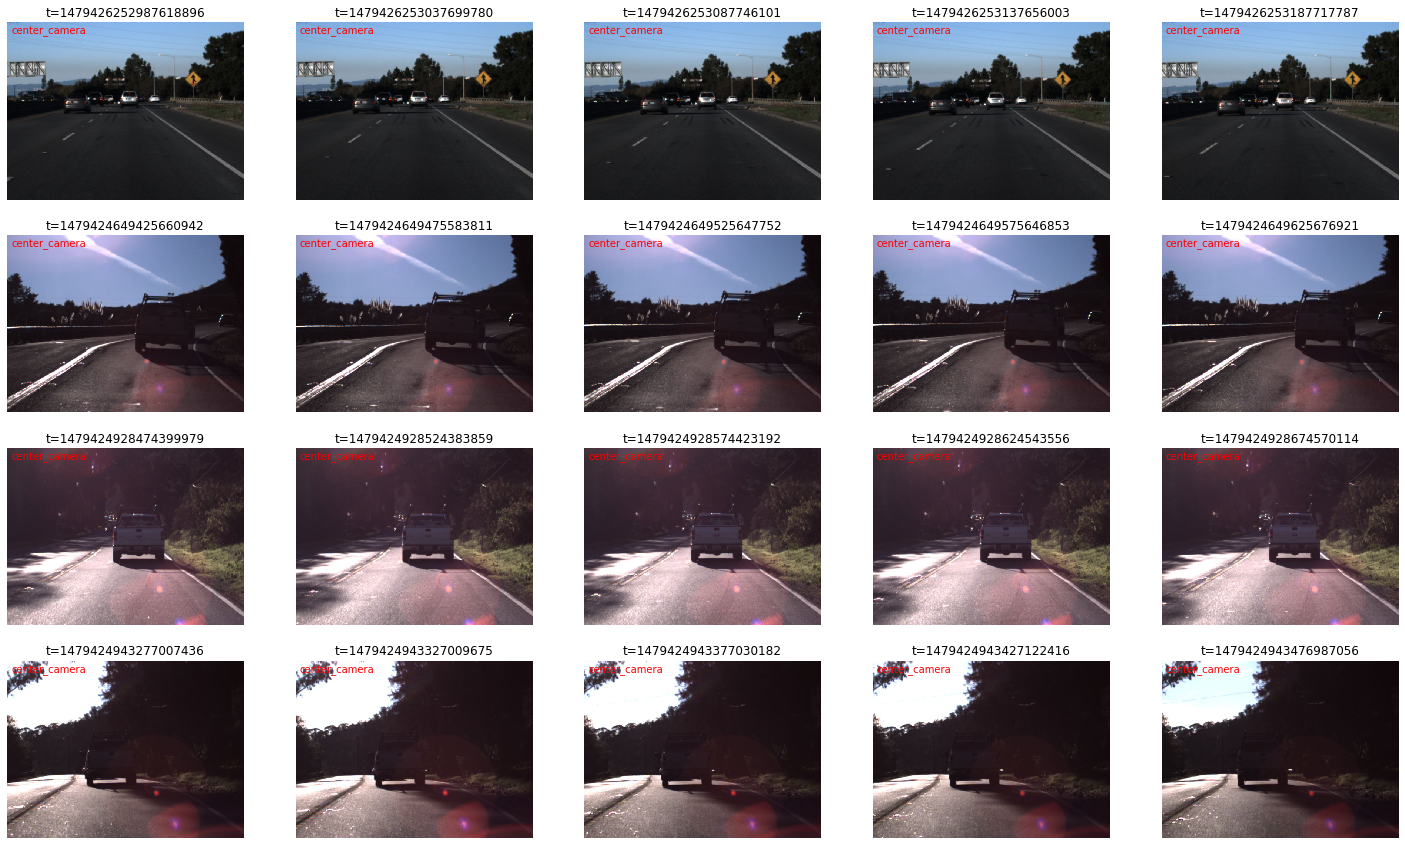

In [514]:
# test the ConsecutiveBatchSampler

# dummy_dataset = list(range(0, 10))
# cbs = ConsecutiveBatchSampler(data_source=dummy_dataset, batch_size=4, seq_len=4, shuffle=True, drop_last=False)
# print("CBS sampled sequence:")
# print(list([a for a in cbs]))
# print("BS sampled sequence:")
# bs = BatchSampler(RandomSampler(dummy_dataset), batch_size=4, drop_last=False)
# print(list([a for a in bs]))
    
#test the sampler on DataLoader

cbs = ConsecutiveBatchSampler(data_source=udacity_dataset, batch_size=4, shuffle=True, drop_last=False, seq_len=5)
dataloader = DataLoader(udacity_dataset, sampler=cbs, num_workers=1, collate_fn=(lambda x: x[0]))
for i_batch, sample_batched in enumerate(dataloader):
    print("Sample image:")
    print(type(sample_batched['image']))
    print(sample_batched['image'].shape)
    print("Sample angle:")
    print(type(sample_batched['angle']))
    print(sample_batched['angle'].shape)
    
    show_sample(sample_batched)
    
    break

In [ ]:
# Model 1
import torch.nn as nn

class Conv3DModel(nn.Module, W_in=640, H_in=480):
    def __init__(self):
        super(Conv3DModel, self).__init__()
        
        
    
    def forward(self, x):
        pass
    
